## История Искусственного Интеллекта
### 6 занятие

Шестой модуль курса по основам Искусственного Интеллекта в GeekBrains посвящён сферам применения Искусственного Интеллекта. Опять же, практическое занятие можно было бы устраивать по каждой теме, но и для этого есть углублённые курсы. Поэтому для общего развития выполните такие задачи:

1. Во вкладке "Материалы" расположен временной ряд за несколько лет.  
2. Используйте любой инструмент для дата майнинга (можно даже ту же самую электронную таблицу).  
3. Найдите закономерности в представленном временном ряду, если они есть.  
4. Сделайте прогноз по тренду.  
5. Напишите краткий отчёт об исследовании и пришлите преподавателю ссылку на него.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (30, 10)

In [2]:
df = pd.read_csv('data_for_analys.csv', names=['data', 'value'], header=0)
df['data'] = pd.to_datetime(df['data'], format='%d.%m.%Y')
df.sort_values(by=['data'], inplace=True)
df = df.set_index('data')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1461 entries, 2014-05-01 to 2018-04-30
Data columns (total 1 columns):
value    1461 non-null int64
dtypes: int64(1)
memory usage: 22.8 KB


In [3]:
df.head()

,value
data,
2014-05-01,0
2014-05-02,10
2014-05-03,0
2014-05-04,0
2014-05-05,0


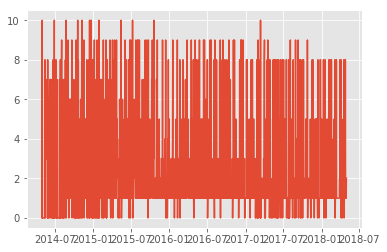

In [4]:
plt.plot(df['value'])
plt.show()

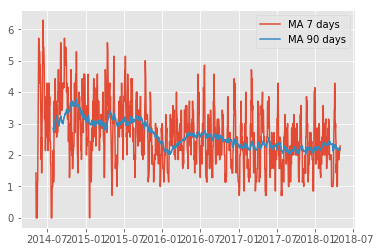

In [5]:
plt.plot(df['value'].rolling(7).mean(),label= 'MA 7 days')
plt.plot(df['value'].rolling(90).mean(),label= 'MA 90 days')
plt.legend(loc='best')
plt.show()

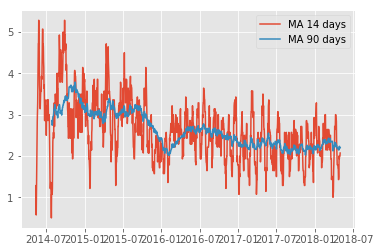

In [6]:
plt.plot(df['value'].rolling(14).mean(),label= 'MA 14 days')
plt.plot(df['value'].rolling(90).mean(),label= 'MA 90 days')
plt.legend(loc='best')
plt.show()

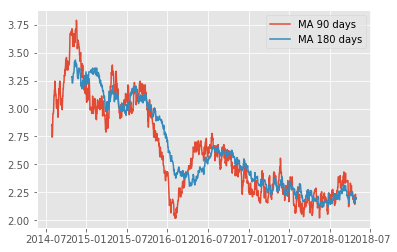

In [7]:
plt.plot(df['value'].rolling(90).mean(),label= 'MA 90 days')
plt.plot(df['value'].rolling(180).mean(),label= 'MA 180 days')
plt.legend(loc='best')
plt.show()

### Закономерности

Есть явная закономерность, в глобальном смысле график стремиться вниз
Так же видна переиодичность в 10-14 дней

### Прогноз по тренду

Далее по материалам  
https://habr.com/ru/company/ods/blog/327242/

In [8]:
pred_len = 30
lern_len = 12

In [9]:
from sklearn.model_selection import TimeSeriesSplit
from scipy.optimize import minimize
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error


def timeseriesCVscore(x):
    # вектор ошибок
    errors = []

    values = data.values
    alpha, beta, gamma = x

    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=3) 

    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen = lern_len, alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()

        predictions = model.result[-len(test):]
        actual = values[test]
        error = mean_squared_error(predictions, actual)
        errors.append(error)

    # Возвращаем средний квадрат ошибки по вектору ошибок 
    return np.mean(np.array(errors))

In [10]:
class HoltWinters:

    """
    Модель Хольта-Винтерса с методом Брутлага для детектирования аномалий
    https://fedcsis.org/proceedings/2012/pliks/118.pdf

    # series - исходный временной ряд
    # slen - длина сезона
    # alpha, beta, gamma - коэффициенты модели Хольта-Винтерса
    # n_preds - горизонт предсказаний
    # scaling_factor - задаёт ширину доверительного интервала по Брутлагу (обычно принимает значения от 2 до 3)

    """

    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor

    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  

    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # вычисляем сезонные средние
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # вычисляем начальные значения
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []

        seasonals = self.initial_seasonal_components()

        for i in range(len(self.series)+self.n_preds):
            if i == 0: # инициализируем значения компонент
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])

                self.PredictedDeviation.append(0)

                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])

                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])

                continue
            if i >= len(self.series): # прогнозируем
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])

                # во время прогноза с каждым шагом увеличиваем неопределенность
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 

            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])

                # Отклонение рассчитывается в соответствии с алгоритмом Брутлага
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])

            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i % self.slen])

In [11]:
%%time
data = df.value[:-500] # отложим часть данных для тестирования

# инициализируем значения параметров
x = [0, 0, 0] 

# Минимизируем функцию потерь с ограничениями на параметры
opt = minimize(timeseriesCVscore, x0=x, method="TNC", bounds = ((0, 1), (0, 1), (0, 1)))

# Из оптимизатора берем оптимальное значение параметров
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

0.03084754528469935 0.012770603457328944 0.007311585157029787
Wall time: 1min 3s


In [12]:
data = df['value']
model = HoltWinters(data[:-pred_len], slen = lern_len, alpha = alpha_final, beta = beta_final, gamma = gamma_final, n_preds = pred_len, scaling_factor = 2.56)
model.triple_exponential_smoothing()

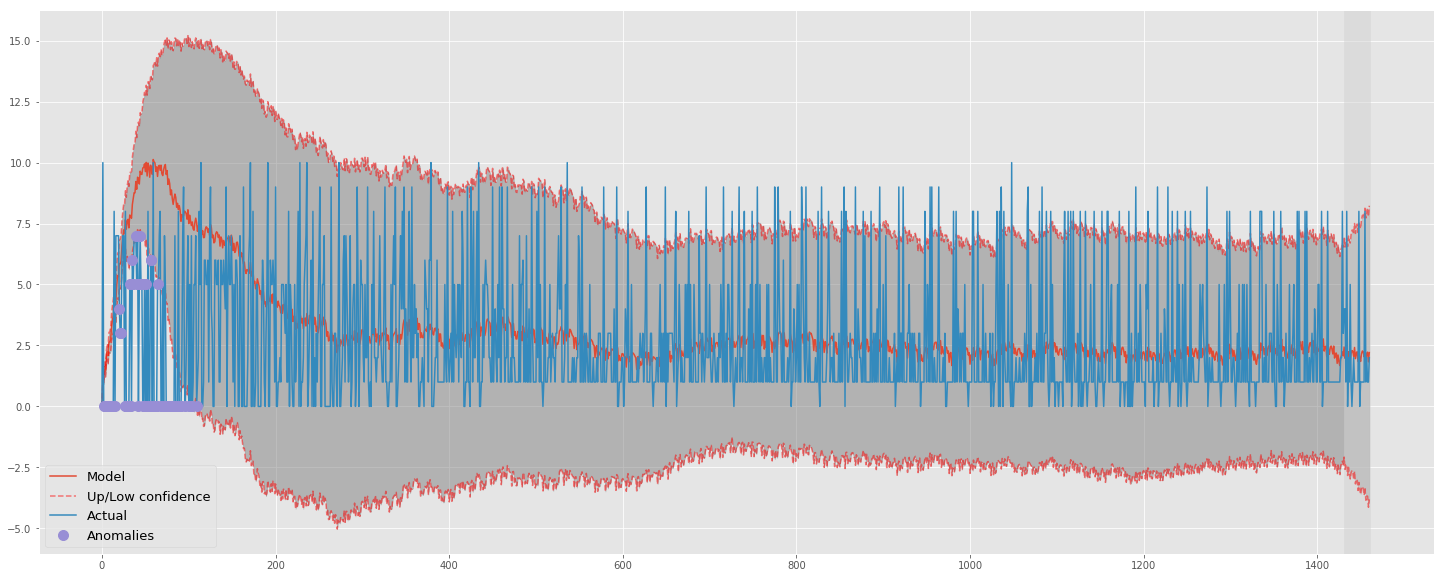

In [13]:
def plotHoltWinters():
    Anomalies = np.array([np.NaN]*len(data))
    Anomalies[data.values<model.LowerBond] = data.values[data.values<model.LowerBond]
    plt.figure(figsize=(25, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
    plt.plot(model.LowerBond, "r--", alpha=0.5)
    plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, y2=model.LowerBond, alpha=0.5, color = "grey")
    plt.plot(data.values, label = "Actual")
    plt.plot(Anomalies, "o", markersize=10, label = "Anomalies")
    plt.axvspan(len(data)-pred_len, len(data), alpha=0.5, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

plotHoltWinters()